In [1]:
import torch
import monai

from monai.transforms import (
    Compose,
    NormalizeIntensityd,
    RandSpatialCropd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    Activations, AsDiscrete,Resized
)
from torch.utils.tensorboard import SummaryWriter

from dataset import HNTSDataset
from trainer import MedSegTrainer
from monai.metrics import DiceMetric

In [2]:
class Config:
    device = "cuda"
    batch_size = 4
    epochs = 400
    lr_init = 1e-4
    lr_min = 1e-10
    cpu_cores = 8
    weight_decay = 1e-5
    smooth_nr = 0
    smooth_dr = 1e-5


config = Config()

In [3]:
# train_transforms = Compose(
#     [
#         # Normalization and cropping
#         # RandSpatialCropd(
#         #     keys=["image", "mask"], roi_size=[224, 224, 96], random_size=False
#         # ),
#         # RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=0),
#         # RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
#         # RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=2),
#         NormalizeIntensityd(keys="image", nonzero=True),
#         # RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
#         # RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
#     ]
# )
# train_dataset = HNTSDataset("data/test", transform=train_transforms)
# train_loader = monai.data.DataLoader(
#     train_dataset,
#     batch_size=config.batch_size,
#     shuffle=True,
#     num_workers=config.cpu_cores,
# )

In [4]:
test_dataset = HNTSDataset("data/test", transform=NormalizeIntensityd(keys="image"))

Loading dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


In [ ]:
monai.data.Dataset()

In [5]:
from definitions.models import get_model

model = get_model("SegResNet").to(config.device)

In [6]:
total_params = torch.tensor(0)
for params in model.parameters():
    n_params = torch.prod(torch.tensor(params.shape))
    total_params += n_params
total_params.item()
# U-Net:      4 739 869
# SegResNet:  5 697 906
# SwinUNETR: 15 703 004
# UNETR:    121 860 322

5697906

In [7]:
optimizer = torch.optim.Adam(model.parameters(), config.lr_init, weight_decay=config.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config.epochs, eta_min=config.lr_min
)
loss_function = monai.losses.DiceCELoss(
    smooth_nr=config.smooth_nr,
    smooth_dr=config.smooth_dr,
    squared_pred=True,
    to_onehot_y=False,  # labels are already separated by channel
    sigmoid=True,  # 0 is background, 1 is label
    weight=torch.tensor([1.1698134, 0.8732383]).to(config.device)
)
experiment_name = "dummy"
writer = SummaryWriter(f"logs/writer/{experiment_name}")
trainer = MedSegTrainer(
    experiment_name=experiment_name,
    model=model,
    epochs=config.epochs,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    loss_f=loss_function,
    writer=writer,
    save_every=50
)

In [8]:
trainer.load_checkpoint("logs/v2/HNTS-SegResNet/checkpoints/16500")

/cluster/work/andrebw/medical-image-segmentation/trainer.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trainer_state_dict: dict = torch.load(f"{checkpoint_path}/trai

In [9]:
trainer.create_prediction_slider_and_video(test_dataset[9])

Creatig prediction slices: 100%|██████████| 161/161 [00:39<00:00,  4.08it/s]


Generating GIF...


In [42]:
from matplotlib import colors
from definitions.colors import GTVp_col, GTVn_col
GTVp_cmap = colors.ListedColormap(["white",GTVp_col])
GTVn_cmap = colors.ListedColormap(["white",GTVn_col])

In [ ]:
import matplotlib.pyplot as plt

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
spl = monai.transforms.Orientation(axcodes="SPL")

sample = test_dataset[9]
image = sample['image']
mask = sample['mask']
pred = trainer.inference(image.unsqueeze(0), raw=True)[0].cpu()
image_spl = spl(image)
mask_spl = spl(mask)
pred_spl = spl(pred)
sample['id']

'158'

(-0.5, 99.5, 99.5, -0.5)

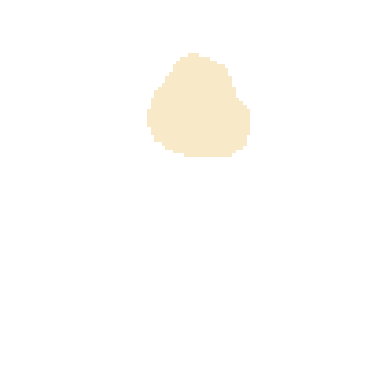

In [108]:
# pred_cropped = monai.transforms.RandSpatialCrop(roi_size=(1000,100,100))(pred_spl)
# plt.imshow(pred_cropped[0,80,:,:].sigmoid().gt(0.5), cmap=GTVp_cmap, alpha=0.5)
plt.imshow(pred_cropped[1,80,:,:].sigmoid().gt(0.5), cmap=GTVn_cmap, alpha=0.5)
# plt.imshow(image_spl[0,80], cmap='gray')
plt.axis('off')

Text(0.5, 1.0, 'Treshold >0.5')

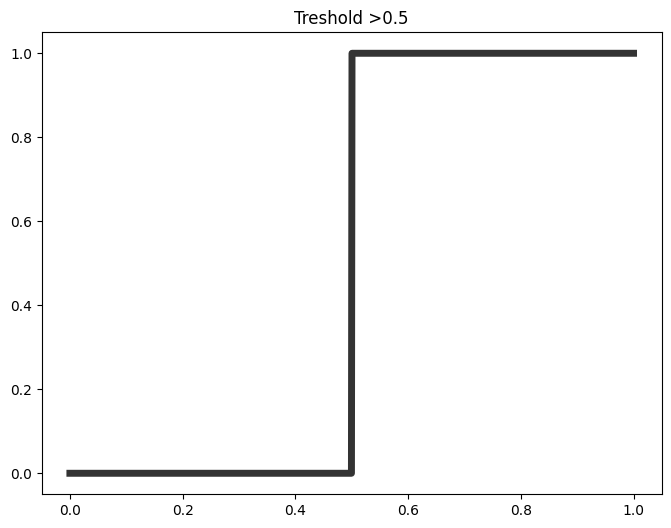

In [144]:
import numpy as np

plt.figure(figsize=(8,6))
x = np.linspace(0, 1, 1000)
plt.plot(x, x>0.5, color="black", alpha=0.8, linewidth=5)
plt.title("Treshold >0.5")
# plt.axis('off')
# plt.grid()

In [111]:
help(np.linspace)

Help on _ArrayFunctionDispatcher in module numpy:

linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)
    Return evenly spaced numbers over a specified interval.
    
    Returns `num` evenly spaced samples, calculated over the
    interval [`start`, `stop`].
    
    The endpoint of the interval can optionally be excluded.
    
    .. versionchanged:: 1.16.0
        Non-scalar `start` and `stop` are now supported.
    
    .. versionchanged:: 1.20.0
        Values are rounded towards ``-inf`` instead of ``0`` when an
        integer ``dtype`` is specified. The old behavior can
        still be obtained with ``np.linspace(start, stop, num).astype(int)``
    
    Parameters
    ----------
    start : array_like
        The starting value of the sequence.
    stop : array_like
        The end value of the sequence, unless `endpoint` is set to False.
        In that case, the sequence consists of all but the last of ``num + 1``
        evenly spaced samples, s

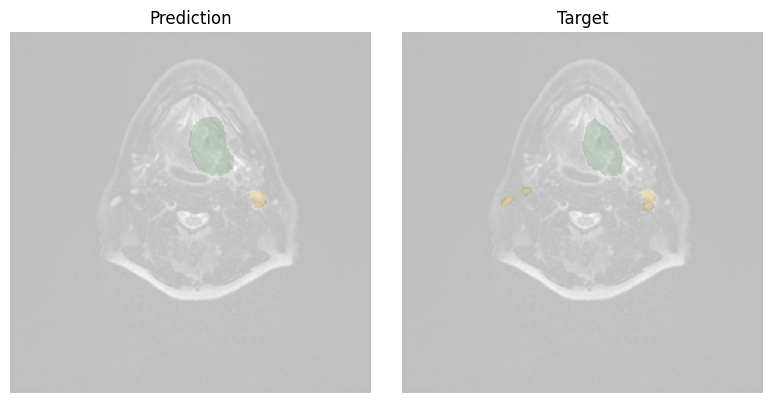

In [ ]:
from matplotlib import colors

GTVp_col = "#80AE80"
GTVn_col = "#F1D691"

f, axs = plt.subplots(1,2, figsize=(8,4))
slice_idx = 81
axs[0].imshow(image_spl[0,slice_idx,:,:]*2, cmap="gray")
axs[0].imshow(pred_spl[0,slice_idx,:,:], cmap=colors.ListedColormap(["white",GTVp_col]), alpha=0.5)
axs[0].imshow(pred_spl[1,slice_idx,:,:], cmap=colors.ListedColormap(["white",GTVn_col]), alpha=0.5)
axs[0].set_title("Prediction")
axs[0].axis('off')
axs[1].imshow(image_spl[0,slice_idx,:,:], cmap="gray")
axs[1].imshow(mask_spl[0,slice_idx,:,:], cmap=colors.ListedColormap(["white",GTVp_col]), alpha=0.5)
axs[1].imshow(mask_spl[1,slice_idx,:,:], cmap=colors.ListedColormap(["white",GTVn_col]), alpha=0.5)
axs[1].set_title("Target")
axs[1].axis('off')
f.tight_layout();

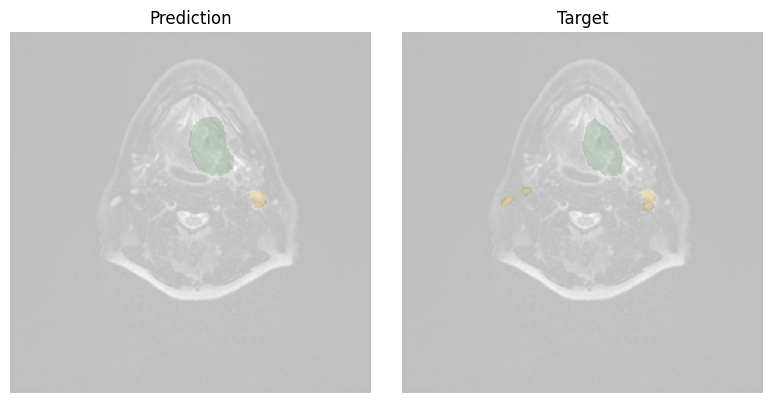

In [ ]:
from matplotlib import colors

GTVp_col = "#80AE80"
GTVn_col = "#F1D691"

f, axs = plt.subplots(1,2, figsize=(8,4))
slice_idx = 81
axs[0].imshow(image_spl[0,slice_idx,:,:]*2, cmap="gray")
axs[0].imshow(pred_spl[0,slice_idx,:,:], cmap=colors.ListedColormap(["white",GTVp_col]), alpha=0.5)
axs[0].imshow(pred_spl[1,slice_idx,:,:], cmap=colors.ListedColormap(["white",GTVn_col]), alpha=0.5)
axs[0].set_title("Prediction")
axs[0].axis('off')
axs[1].imshow(image_spl[0,slice_idx,:,:], cmap="gray")
axs[1].imshow(mask_spl[0,slice_idx,:,:], cmap=colors.ListedColormap(["white",GTVp_col]), alpha=0.5)
axs[1].imshow(mask_spl[1,slice_idx,:,:], cmap=colors.ListedColormap(["white",GTVn_col]), alpha=0.5)
axs[1].set_title("Target")
axs[1].axis('off')
f.tight_layout();

In [71]:
help(monai.transforms.CenterSpatialCrop)

Help on class CenterSpatialCrop in module monai.transforms.croppad.array:

class CenterSpatialCrop(Crop)
 |  CenterSpatialCrop(roi_size: 'Sequence[int] | int', lazy: 'bool' = False) -> 'None'
 |  
 |  Crop at the center of image with specified ROI size.
 |  If a dimension of the expected ROI size is larger than the input image size, will not crop that dimension.
 |  So the cropped result may be smaller than the expected ROI, and the cropped results of several images may
 |  not have exactly the same shape.
 |  
 |  This transform is capable of lazy execution. See the :ref:`Lazy Resampling topic<lazy_resampling>`
 |  for more information.
 |  
 |  Args:
 |      roi_size: the spatial size of the crop region e.g. [224,224,128]
 |          if a dimension of ROI size is larger than image size, will not crop that dimension of the image.
 |          If its components have non-positive values, the corresponding size of input image will be used.
 |          for example: if the spatial size of i

In [31]:
image_spl.max()

metatensor(10.9666)

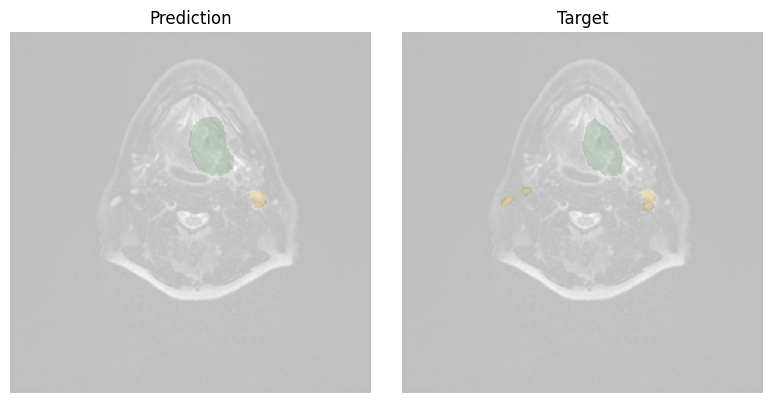

In [37]:
from matplotlib import colors

GTVp_col = "#80AE80"
GTVn_col = "#F1D691"

f, axs = plt.subplots(1,2, figsize=(8,4))
slice_idx = 81
axs[0].imshow(image_spl[0,slice_idx,:,:]*2, cmap="gray")
axs[0].imshow(pred_spl[0,slice_idx,:,:], cmap=colors.ListedColormap(["white",GTVp_col]), alpha=0.5)
axs[0].imshow(pred_spl[1,slice_idx,:,:], cmap=colors.ListedColormap(["white",GTVn_col]), alpha=0.5)
axs[0].set_title("Prediction")
axs[0].axis('off')
axs[1].imshow(image_spl[0,slice_idx,:,:], cmap="gray")
axs[1].imshow(mask_spl[0,slice_idx,:,:], cmap=colors.ListedColormap(["white",GTVp_col]), alpha=0.5)
axs[1].imshow(mask_spl[1,slice_idx,:,:], cmap=colors.ListedColormap(["white",GTVn_col]), alpha=0.5)
axs[1].set_title("Target")
axs[1].axis('off')
f.tight_layout();

In [ ]:
pred_nifty = torch.zeros_like(pred).sum(0)#.unsqueeze(0)
pred_nifty[pred[0] == 1] = 1
pred_nifty[pred[1] == 1] = 2
pred_nifty = pred.sum(0).unsqueeze(0)
pred_nifty.shape, pred.shape

(torch.Size([1, 256, 256, 149]), torch.Size([2, 256, 256, 149]))

In [41]:
from monai.transforms import SaveImage

save = SaveImage(
    output_dir="./predictions",  # Directory to save the output
    output_postfix="prediction",  # Add this to the filename
    output_ext=".nii.gz",  # File extension
    resample=False,  # Avoid resampling
    writer="NibabelWriter",
)

save(pred_nifty,
     meta_data={"meta": {**mask.meta}}
);

2024-11-26 21:47:22,463 INFO image_writer.py:197 - writing: predictions/104_preRT_T2/104_preRT_T2_prediction.nii.gz


In [ ]:
torch.clear_autocast_cache()
test_dataset = HNTSDataset("data/test", transform=NormalizeIntensityd(keys="image"))
test_loader = monai.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=config.cpu_cores,
)

In [ ]:
metrics_dict = {
    "IoU": monai.metrics.MeanIoU(include_background=True, reduction="mean"),
    "Dice": monai.metrics.DiceMetric(include_background=True, reduction="mean"),
    "DiceBatched": monai.metrics.DiceMetric(
        include_background=True, reduction="mean_batch"
    ),
}

score = trainer.test(
    test_loader=test_loader,
    metrics=metrics_dict,
)

print(f"Metrics: {score}")

In [53]:
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

sample_idx = 9
sample = test_dataset[sample_idx]
image = sample['image']
mask_pred = trainer.inference(image.unsqueeze(0))[0].cpu()

to_spl = monai.transforms.Orientation(axcodes="SPL")
image = to_spl(sample['image'])
mask_target = to_spl(sample['mask'])
mask_pred = to_spl(mask_pred)

def plot_slice(slice_idx):
    image_slice =  image[0,slice_idx]
    label0 = [mask_pred[0,slice_idx], mask_target[0,slice_idx]]
    label1 = [mask_pred[1,slice_idx], mask_target[1,slice_idx]]
    title = ['Prediction', 'Target']
    cols = [GTVp_col, GTVn_col]

    fig, axs = plt.subplots(1,2,figsize=(12,6))
    for i in range(2):
        axs[i].imshow(image_slice, cmap="gray", alpha=1.0)
        axs[i].imshow(label0[i], cmap=colors.ListedColormap(["white",cols[0]]), alpha=0.5)
        axs[i].imshow(label1[i], cmap=colors.ListedColormap(["white",cols[1]]), alpha=0.5)
        axs[i].set_title(title[i])
        axs[i].axis('off')
    fig.tight_layout()
    fig.show()
slider = widgets.IntSlider(value=mask_pred.shape[1]//2, min=0, max=mask_pred.shape[1]-1, step=1, description='Slice Index')
interact(plot_slice, slice_idx=slider);

interactive(children=(IntSlider(value=80, description='Slice Index', max=160), Output()), _dom_classes=('widge…

In [ ]:
image = sample["image"]
mask_target = sample["mask"]
mask_pred = trainer.inference(trainer.model, image.unsqueeze(0))[0].cpu()

image = monai.transforms.Orientation(axcodes="SPL")(image)
mask_target = monai.transforms.Orientation(axcodes="SPL")(mask_target)
mask_pred = monai.transforms.Orientation(axcodes="SPL")(mask_pred)

title = ["Prediction", "Target"]
cols = [GTVp_col, GTVn_col]
for slice_idx in range(mask_target.shape[1]):
    image_slice = image[0, slice_idx]
    label0 = [mask_pred[0, slice_idx], mask_target[0, slice_idx]]
    label1 = [mask_pred[1, slice_idx], mask_target[1, slice_idx]]
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    for i in range(2):
        axs[i].imshow(image_slice, cmap="gray", alpha=1.0)
        axs[i].imshow(label0[i], cmap=colors.ListedColormap(["white",cols[i]]), alpha=0.3)
        axs[i].imshow(label1[i], cmap=colors.ListedColormap(["white",cols[i]]), alpha=0.3)
        axs[i].set_title(title[i])
        axs[i].axis("off")
    plt.tight_layout()
    writer.add_figure("prediction_vs_target", fig, global_step=slice_idx)